/home/daniel/PycharmProjects/WageringSystem/venv/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/daniel/PycharmProjects/WageringSystem/venv/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/daniel/PycharmProjects/WageringSystem/venv/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/daniel/PycharmProjects/WageringSystem/venv/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style,

Max draw down of soft payouts: 33.479309200015734
% of positive clv: 0.511265164644714
count    1731.000000
mean        0.055585
std         0.396021
min        -0.793467
25%        -0.218608
50%         0.012334
75%         0.267465
max         2.305830
dtype: float64
Expected/Actual wins: 342.77220800791923/331
Win percentage: 0.19121894858463315
575.4207862032283
65.51293364557665


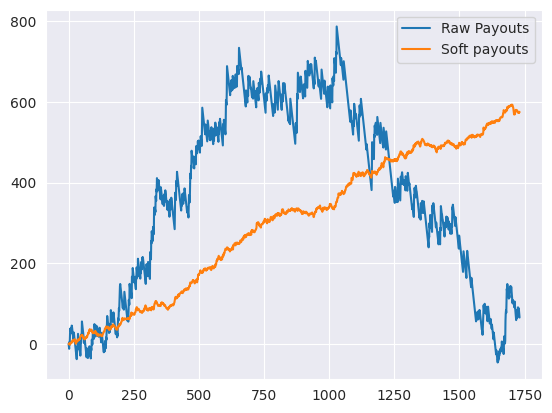

In [19]:
from DataAbstraction.Present.RaceCard import RaceCard
from Persistence.RaceCardPersistence import RaceDataPersistence
from Model.Betting.bet import LiveResult
from math import isnan
import os
import pandas as pd
from tqdm import tqdm
from util.stats_calculator import get_max_draw_down
from util.plot import plot_wealth_growth
from typing import List, Dict
from DataAbstraction.util.track_name_mapping import get_unique_track_name
from IPython.display import display

def get_live_results(live_bets_file_name: str, race_cards: Dict[str, RaceCard]) -> List[LiveResult]:
    header_row = 3
    bets_df = pd.read_excel(live_bets_file_name, header=header_row)
    
    name_pattern = r'/ (.*?) /'
    
    pattern = r'^(.*?)\s(\d{1,2})\s\w{3}\s/'
    
    bets_df['Name'] = bets_df['Description'].str.extract(name_pattern)
    bets_df["Name"] = bets_df["Name"].str.lower()
    
    # Use str.extract() to extract the track name, day, and month and create new columns
    bets_df[['Track', 'Day']] = bets_df['Description'].str.extract(pattern)
    bets_df["Track"] = bets_df["Track"].apply(get_unique_track_name)
    bets_df["Day"] = bets_df["Day"].astype(int)
    
    # display(bets_df[bets_df["Track"] == "Ascot"])
    
    sp_data = {"Track": [], "Day": [], "Name": [], "SP": []}
        
    for race_card in race_cards.values():
        for runner in race_card.runners:
            sp_data["Track"].append(race_card.track_name)
            sp_data["Day"].append(race_card.datetime.day)
            sp_data["Name"].append(runner.name.replace("'", "").lower())
            sp_data["SP"].append(runner.win_sp)
            
    sp_df = pd.DataFrame.from_dict(sp_data)
    bets_sp_df = pd.merge(bets_df, sp_df, on=["Track", "Day", "Name"], how="inner")
    
    live_results = []
    bets_sp_df = bets_sp_df.sort_values(by="Day")
    # bets_sp_df = bets_sp_df[bets_sp_df['Description'].str.contains('Win', case=False, na=False)]
    for row in bets_sp_df.itertuples(index=False):
        if isnan(row.SP):
            print(row)
        has_won = row.Status == "Won"
        win = 0
        if has_won:
            win = row.Stake * row.Odds
        live_results.append(LiveResult(row.Odds, row.SP, has_won, win=win, loss=row.Stake, stakes=row.Stake))
        
    return live_results
    
race_cards_loader = RaceDataPersistence("race_cards_release")
live_bets_dir = "../data/live_bets"
live_results = []
for i, live_bets_file_name in enumerate(sorted(os.listdir(live_bets_dir))):
    race_card_file_name = race_cards_loader.race_data_file_names[-5 + i]
    race_cards = race_cards_loader.load_race_card_files_non_writable([race_card_file_name])
    live_results += get_live_results(os.path.join(live_bets_dir, live_bets_file_name), race_cards)
    
# live_results = live_results[-4:]
#---------------------------------------------------------
clvs = [result.clv for result in live_results]
soft_payouts = [result.clv * result.stakes for result in live_results]
print(f"Max draw down of soft payouts: {get_max_draw_down(soft_payouts)}")
positive_clv_percentage = len([1 for payout in soft_payouts if payout > 0]) / len(soft_payouts)
print(f"% of positive clv: {positive_clv_percentage}")

payouts = [result.profit for result in live_results]
print(pd.Series(clvs).describe())

expected_wins = sum([1 / live_result.starting_odds for live_result in live_results])
n_wins = sum([1 for live_result in live_results if live_result.has_won])
print(f"Expected/Actual wins: {expected_wins}/{n_wins}")
print(f"Win percentage: {n_wins / len(live_results)}")

plot_wealth_growth(payouts, label="Raw Payouts")
plot_wealth_growth(soft_payouts, label="Soft payouts")
print(sum(soft_payouts))
print(sum([live_result.profit for live_result in live_results]))

In [2]:
import os

from util.stats_calculator import get_max_draw_down
from typing import List
from util.plot import plot_wealth_growth
import pandas as pd
import csv

def row_to_live_result(row: List[str]) -> LiveResult:
    return LiveResult(float(row[0]), float(row[1]), row[3]=="True", stakes=float(row[2]))

with open('live_results.csv', newline='') as csvfile:
    live_result_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    
    live_results = [row_to_live_result(row) for row in live_result_reader]

clvs = [result.clv for result in live_results]
soft_payouts = [result.clv * result.stakes for result in live_results]
print(f"Max draw down of soft payouts: {get_max_draw_down(soft_payouts)}")
positive_clv_percentage = len([1 for payout in soft_payouts if payout > 0]) / len(soft_payouts)
print(f"% of positive clv: {positive_clv_percentage}")

payouts = [get_payout(result, result.stakes) for result in live_results]
print(pd.Series(clvs).describe())

expected_wins = sum([1 / live_result.starting_odds for live_result in live_results])
n_wins = sum([1 for live_result in live_results if live_result.has_won])
print(f"Expected/Actual wins: {expected_wins}/{n_wins}")
print(f"Win percentage: {n_wins / len(live_results)}")

plot_wealth_growth(payouts, label="Raw Payouts")
plot_wealth_growth(soft_payouts, label="Soft payouts")

TypeError: __init__() missing 2 required positional arguments: 'win' and 'loss'

8.0
8.024000000000001
8.1138688
8.142105063424001
8.082179170157199
8.009762844792592
7.94568474203425
7.960622629349275
8.123337755893173
7.827648261578662
7.822325460760788
8.090474777555668
8.111510011977312
8.13746684401564
8.12216840634889
8.238477857927807
8.303397063448278
8.333953564641769
8.33462028092694
8.501979456167952
8.188426453824478
8.715106043334469
8.722078128169136
8.828836364457926
9.860044451826612
10.04383568040866
9.711585596100742
9.687112400398568
10.072659473934431
9.871206284455742
10.501778941906775
Lowest bankroll: 1955.581365190197


<AxesSubplot:>

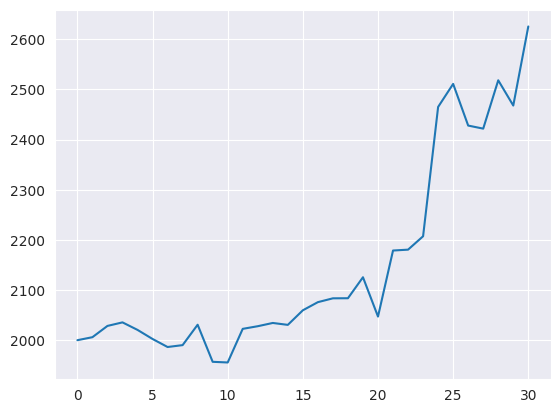

In [2]:
import csv
import seaborn as sns

STAKING_FRACTION = 0.004
bankroll = 2000
bankroll_snapshots = []

current_staking_size = max(STAKING_FRACTION * bankroll, 6)

with open('live_results.csv', newline='') as csvfile:
    live_result_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    
    profit_of_day = 0
    for row in live_result_reader:
        is_new_day = int(row[4]) == 1
        
        if is_new_day:
            bankroll += profit_of_day
            bankroll_snapshots.append(bankroll)
            profit_of_day = 0
            current_staking_size = max(STAKING_FRACTION * bankroll, 6)
            print(current_staking_size)
        
        offer_odds = float(row[0])
        has_won = row[3]=="True"
        
        profit_of_day -= current_staking_size
        if has_won:
            profit_of_day += offer_odds * current_staking_size

print(f"Lowest bankroll: {min(bankroll_snapshots)}")
sns.lineplot(bankroll_snapshots)

In [32]:
import numpy as np
import seaborn as sns

recent_live_results = live_results[-50:]
recent_live_results *= 100

end_wealths = []
min_wealths = []
final_negative_idx_list = []
for _ in range(1000):
    idx = 0
    final_negative_idx = idx
    wealth = 0
    min_wealth = 0
    for result in recent_live_results:
        win_p = 1 / result.starting_odds
        if np.random.rand() <= win_p:
            wealth_change = result.offer_odds - 1
        else:
            wealth_change = -1
        wealth += wealth_change
        idx += 1
        if wealth <= 0:
            final_negative_idx = idx
        if wealth < min_wealth:
            min_wealth = wealth
        
    end_wealths.append(wealth)
    min_wealths.append(min_wealth)
    final_negative_idx_list.append(final_negative_idx)
    
print(pd.Series(end_wealths).describe())
print(pd.Series(min_wealths).describe())
print(pd.Series(final_negative_idx_list).describe())

count    1000.000000
mean      450.517705
std       139.079241
min       -11.881708
25%       353.881082
50%       442.546102
75%       543.989930
max       869.280018
dtype: float64
count    1000.000000
mean      -18.420218
std        19.840730
min      -124.246737
25%       -26.074334
50%       -12.372730
75%        -4.000000
max         0.000000
dtype: float64
count    1000.000000
mean      435.309000
std       631.927768
min         0.000000
25%        25.000000
50%       190.000000
75%       574.250000
max      5000.000000
dtype: float64


In [2]:
from scipy.stats import pearsonr
import seaborn as sns

offer_odds = [result.offer_odds for result in live_results]
sns.scatterplot(x=offer_odds, y=clvs)

pearsonr(x=offer_odds, y=clvs)

In [28]:
bets_per_day = 7
wealth = 16000
loss_counter = 0

while wealth > 100:
    loss_per_bet = max([6, wealth * 0.01])
    loss_counter += bets_per_day
    wealth -= loss_per_bet * bets_per_day
    
print(loss_counter)

406
